# Cookie Cats A/B Test Result Data Analysis

https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats

## Check Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import chi2, chi2_contingency

In [2]:
df = pd.read_csv("./Data/preprocessed_cookie_cats.csv", encoding="utf-8")

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,337,gate_30,38,1,0
1,377,gate_40,165,1,0
2,488,gate_40,179,1,1
3,540,gate_40,187,1,1
4,1574,gate_40,108,1,1


In [4]:
df.shape

(33268, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33268 entries, 0 to 33267
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          33268 non-null  int64 
 1   version         33268 non-null  object
 2   sum_gamerounds  33268 non-null  int64 
 3   retention_1     33268 non-null  int64 
 4   retention_7     33268 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.3+ MB


## Data analysis and testing

Check retention_1, retention_7 column data distribution

In [6]:
pd.crosstab(df["retention_1"], df["retention_7"])

retention_7,0,1
retention_1,,
0,4328,2278
1,14489,12173


In [7]:
table = pd.crosstab(df["retention_1"], df["retention_7"])
table.index = ["No", "Yes"]
table.columns = ["No", "Yes"]
table

,No,Yes
No,4328,2278
Yes,14489,12173


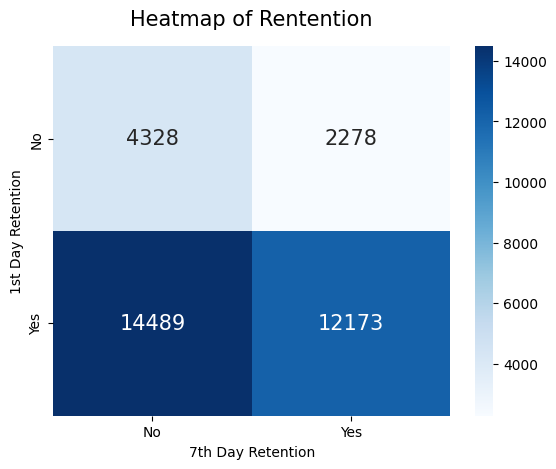

In [8]:
sns.heatmap(table, annot=True, fmt="d", cmap="Blues", annot_kws={"fontsize": 15})

plt.title("Heatmap of Rentention", size=15, pad=15)
plt.xlabel("7th Day Retention")
plt.ylabel("1st Day Retention")
plt.savefig("./Result/rentention.png", bbox_inches="tight")

Ratio of gate_30 and gate_40 in version column

In [9]:
sns.set(style="darkgrid")
palette = sns.color_palette("Set2")
colors = palette.as_hex()

In [10]:
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,16655
gate_40,16613


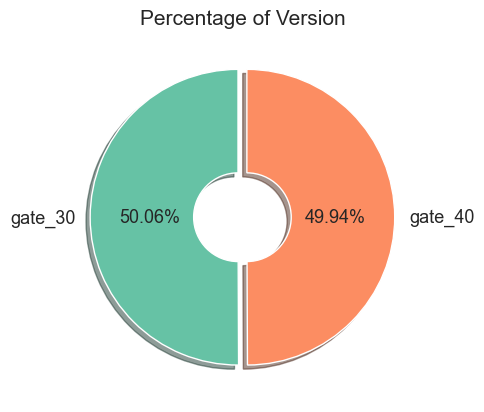

In [11]:
version_count = df.version.value_counts(sort=False)

plt.pie(version_count,
        labels=version_count.index,
        autopct='%1.2f%%',
        startangle=90,
        colors=palette,
        explode=[0.03, 0.03],
        shadow=True,
        textprops={"fontsize": 13},
        wedgeprops={"width": 0.7})
plt.title("Percentage of Version", size=15)
plt.savefig("./Result/version.png", bbox_inches="tight")

Comparison of average number of game rounds by group

In [12]:
df.groupby("version")[["sum_gamerounds"]].describe()

sum_gamerounds                                                   \
                 count        mean         std   min   25%   50%    75%   
version                                                                   
gate_30        16655.0  122.092645  140.954996  30.0  44.0  72.0  143.0   
gate_40        16613.0  124.466502  143.779800  30.0  46.0  75.0  144.0   

                 
            max  
version          
gate_30  2961.0  
gate_40  2640.0

In [13]:
sum_gamerounds_version = df.groupby("version")[["sum_gamerounds"]].mean()
sum_gamerounds_version

,sum_gamerounds
version,
gate_30,122.092645
gate_40,124.466502


C:\Users\minni\AppData\Local\Temp\ipykernel_238404\624888018.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=sum_gamerounds_version, x="version", y="sum_gamerounds", palette=palette)
C:\Users\minni\AppData\Local\Temp\ipykernel_238404\624888018.py:1: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(data=sum_gamerounds_version, x="version", y="sum_gamerounds", palette=palette)


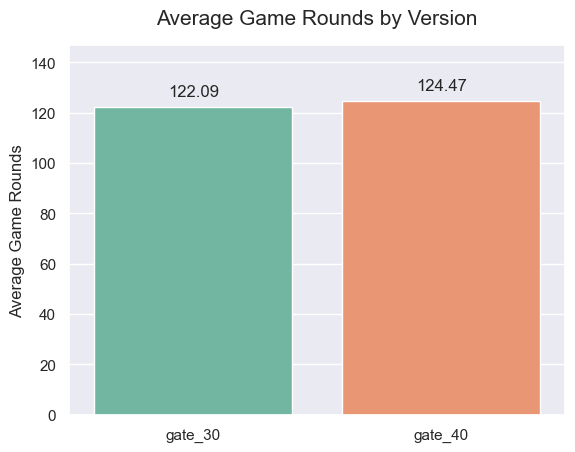

In [14]:
ax = sns.barplot(data=sum_gamerounds_version, x="version", y="sum_gamerounds", palette=palette)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x()+p.get_width()/2, p.get_height()), 
                ha="center", 
                xytext=(0, 8), 
                textcoords="offset points",
                fontsize=12)

plt.margins(y=0.18)
plt.title("Average Game Rounds by Version", size=15, pad=15)
plt.xlabel("")
plt.ylabel("Average Game Rounds")
plt.savefig("./Result/version_sum_gamerounds.png", bbox_inches="tight")

Simply comparing means doesn't tell  whether the difference is statistically significant
<br>
Therefore, use a t-test to test whether the averages of the number of play rounds in the gate_30 group and the gate_40 group are the same or different

1. Hypothesis setting
<br>
Null hypothesis: The difference between the average number of game rounds between the gate_30 group and the gate_40 group is 0.
<br>
Alternative hypothesis: The difference between the average number of game rounds between the gate_30 group and the gate_40 group is not 0. (two-sided test)

2. levene test and two sample t-test test

In [15]:
gate_30 = df[df.version == "gate_30"]["sum_gamerounds"]
gate_40 = df[df.version == "gate_40"]["sum_gamerounds"]

stat, p_value = stats.levene(gate_30, gate_40)

if p_value < 0.05:
    t_stat, p_value = stats.ttest_ind(
    a=gate_30,
    b=gate_40,
    alternative="two-sided",
    equal_var=False
    )
    print("levene test result : different variance")
else:
    t_stat, p_value = stats.ttest_ind(
    a=gate_30,
    b=gate_40,
    alternative="two-sided",
    equal_var=True
    )
    print("levene test result : equal variance")
    
if p_value < 0.05:
    print(f"p-value : {round(p_value, 4)}, Reject null hypothesis")
    print("The average number of game rounds for gate_30 and gate_40 are different.")
else:
    print(f"p-value : {round(p_value, 4)}, Reject alternative hypothesis")
    print("The average number of game rounds for gate_30 and gate_40 are same.")

levene test result : equal variance
p-value : 0.1284, Reject alternative hypothesis
The average number of game rounds for gate_30 and gate_40 are same.


retention_1 column (1st day access rate)

In [16]:
palette = sns.color_palette("pastel")
colors = palette.as_hex()
selected_colors = [colors[4], colors[3]]

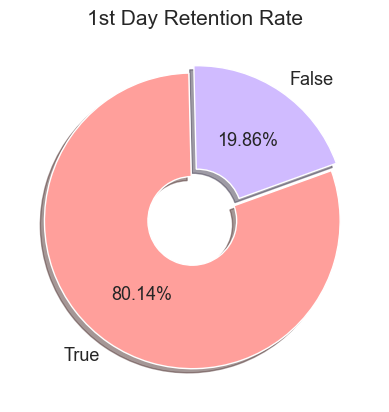

In [17]:
retention_1_count = df.retention_1.value_counts().sort_index()

plt.pie(retention_1_count,
        labels=["False", "True"],
        autopct='%1.2f%%',
        startangle=19.86,
        colors=selected_colors,
        explode=[0.03, 0.03],
        shadow=True,
        textprops={"fontsize": 13},
        wedgeprops={"width": 0.7})
plt.title("1st Day Retention Rate", size=15)
plt.savefig("./Result/retention_1.png", bbox_inches="tight")

1st day access rate by group

In [18]:
version_retention_1_count = df.groupby(["version", "retention_1"]).size().unstack()
retention_1_rate = version_retention_1_count.div(version_retention_1_count.sum(axis=1), axis=0) * 100
retention_1_rate.columns = ["False", "True"]
retention_1_rate

,False,True
version,,
gate_30,19.897929,80.102071
gate_40,19.815807,80.184193


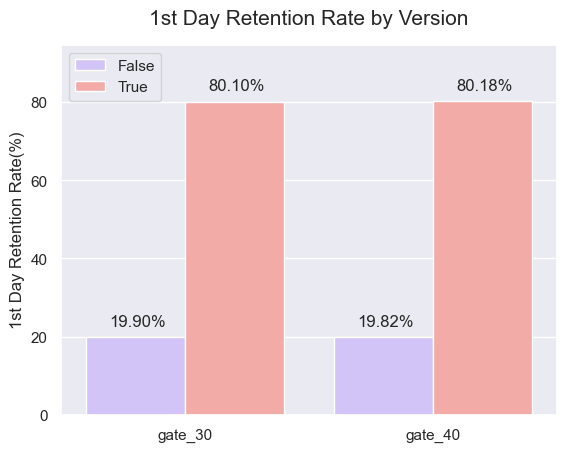

In [19]:
retention_1_rates = retention_1_rate.reset_index().melt(id_vars="version", var_name="retention_1", value_name="rate")

ax = sns.barplot(data=retention_1_rates, x="version", y="rate", hue="retention_1", palette=selected_colors)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{height:.2f}%", (p.get_x()+p.get_width()/2+0.01, height), 
                    ha="center", 
                    xytext=(0, 8), 
                    textcoords="offset points",
                    fontsize=12)

legend = ax.get_legend()
if legend is not None:
    legend.set_title(None)
plt.margins(y=0.18)
plt.title("1st Day Retention Rate by Version", size=15, pad=15)
plt.xlabel("")
plt.ylabel("1st Day Retention Rate(%)")
plt.savefig("./Result/version_retention_1.png", bbox_inches="tight")

Regardless of the group, the retention rate on 1st day appears to be similar
<br>
However, simply comparing means does not tell whether the difference is statistically significant
<br>
Use the chi_squared test to test whether version and retention_1 are independent

1. Hypothesis setting
<br>
Null hypothesis: The two variables version and retention_1 are independent
<br>
Alternative hypothesis: The two variables version and retention_1 are not independent

2. chi_squre test

In [20]:
table1 = pd.crosstab(df["version"], df["retention_1"])
table1

retention_1,0,1
version,,
gate_30,3314,13341
gate_40,3292,13321


In [21]:
chi2_stat, p_value, _, expected = chi2_contingency(table1)
pd.DataFrame(expected, index=table1.index, columns=table1.columns)

retention_1,0,1
version,,
gate_30,3307.169953,13347.830047
gate_40,3298.830047,13314.169953


In [22]:
if p_value < 0.05:
    print(f"p-value : {round(p_value, 4)}, Reject the null hypothesis")
    print("The two variables version and retention_1 are not independent.")
else:
    print(f"p-value : {round(p_value, 4)}, Reject alternative hypothesis")
    print("The two variables version and retention_1 are independent.")

p-value : 0.8619, Reject alternative hypothesis
The two variables version and retention_1 are independent.


retention_7 column (7th day access rate)

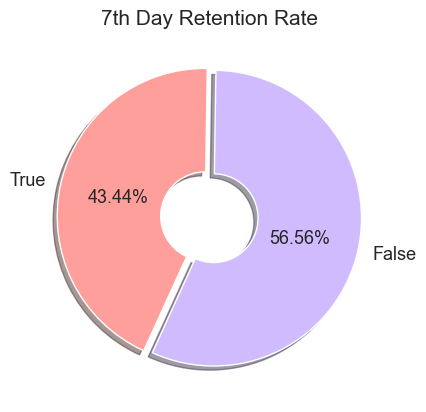

In [23]:
retention_7_count = df.retention_7.value_counts().sort_index()

plt.pie(retention_7_count,
        labels=["False", "True"],
        autopct='%1.2f%%',
        startangle=245.5,
        colors=selected_colors,
        explode=[0.03, 0.03],
        shadow=True,
        textprops={"fontsize": 13},
        wedgeprops={"width": 0.7})
plt.title("7th Day Retention Rate", size=15)
plt.savefig("./Result/retention_7.png", bbox_inches="tight")

7th day access rate by group

In [24]:
version_retention_7_count = df.groupby(["version", "retention_7"]).size().unstack()
retention_7_rate = version_retention_7_count.div(version_retention_7_count.sum(axis=1), axis=0) * 100
retention_7_rate.columns = ["False", "True"]
retention_7_rate

,False,True
version,,
gate_30,56.127289,43.872711
gate_40,56.997532,43.002468


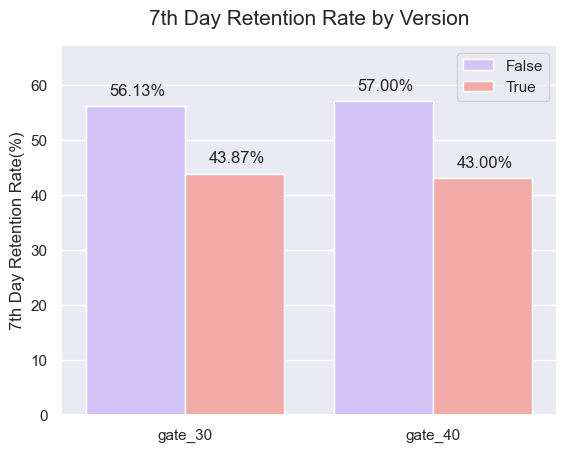

In [25]:
retention_7_rates = retention_7_rate.reset_index().melt(id_vars="version", var_name="retention_7", value_name="rate")

ax = sns.barplot(data=retention_7_rates, x="version", y="rate", hue="retention_7", palette=selected_colors)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{height:.2f}%", (p.get_x()+p.get_width()/2+0.01, height), 
                    ha="center", 
                    xytext=(0, 8), 
                    textcoords="offset points",
                    fontsize=12)

legend = ax.get_legend()
if legend is not None:
    legend.set_title(None)
plt.margins(y=0.18)
plt.title("7th Day Retention Rate by Version", size=15, pad=15)
plt.xlabel("")
plt.ylabel("7th Day Retention Rate(%)")
plt.savefig("./Result/version_retention_7.png", bbox_inches="tight")

Regardless of the group, the retention rate at 7th day appears to be similar
<br>
However, simply comparing means does not tell whether the difference is statistically significant
<br>
Use the chi_squared test to test whether version and retention_7 are independent

1. Hypothesis setting
<br>
Null hypothesis: The two variables version and retention_7 are independent
<br>
Alternative hypothesis: The two variables version and retention_7 are not independent

2. chi_squre test

In [26]:
table2 = pd.crosstab(df["version"], df["retention_7"])
table2

retention_7,0,1
version,,
gate_30,9348,7307
gate_40,9469,7144


In [27]:
chi2_stat, p_value, _, expected = chi2_contingency(table2)
pd.DataFrame(expected, index=table2.index, columns=table2.columns)

retention_7,0,1
version,,
gate_30,9420.377991,7234.622009
gate_40,9396.622009,7216.377991


In [28]:
if p_value < 0.05:
    print(f"p-value : {round(p_value, 4)}, Reject the null hypothesis")
    print("The two variables version and retention_7 are not independent.")
else:
    print(f"p-value : {round(p_value, 4)}, Reject alternative hypothesis")
    print("The two variables version and retention_7 are independent.")

p-value : 0.1118, Reject alternative hypothesis
The two variables version and retention_7 are independent.


Test with bootstrapping method

In [29]:
palette = sns.color_palette("Set2")
colors = palette.as_hex()

In [30]:
retention_df = df.groupby("version")[["retention_1", "retention_7"]].mean() * 100
sum_gamerounds_df = df.groupby("version")[["sum_gamerounds"]].mean()
pd.merge(retention_df, sum_gamerounds_df, on="version")

,retention_1,retention_7,sum_gamerounds
version,,,
gate_30,80.102071,43.872711,122.092645
gate_40,80.184193,43.002468,124.466502


In [31]:
boot1 = []
boot7 = []

for i in range(500):
    boot1_mean = df.sample(frac=1, replace=True).groupby("version")["retention_1"].mean()
    boot7_mean = df.sample(frac=1, replace=True).groupby("version")["retention_7"].mean()
    boot1.append(boot1_mean)
    boot7.append(boot7_mean)

boot1_df = pd.DataFrame(boot1)
boot7_df = pd.DataFrame(boot7)

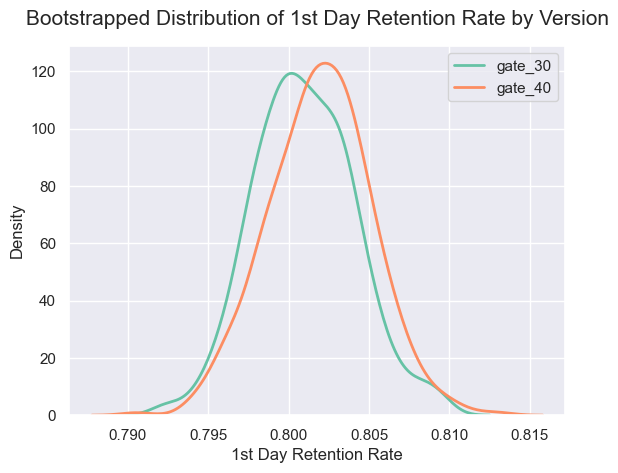

In [32]:
sns.kdeplot(boot1_df["gate_30"], linewidth=2, c=colors[0], label="gate_30")
sns.kdeplot(boot1_df["gate_40"], linewidth=2, c=colors[1], label="gate_40")
plt.title("Bootstrapped Distribution of 1st Day Retention Rate by Version", size=15, pad=15)
plt.xlabel("1st Day Retention Rate")
plt.legend()
plt.savefig("./Result/boot_version_retention_1.png", bbox_inches="tight")

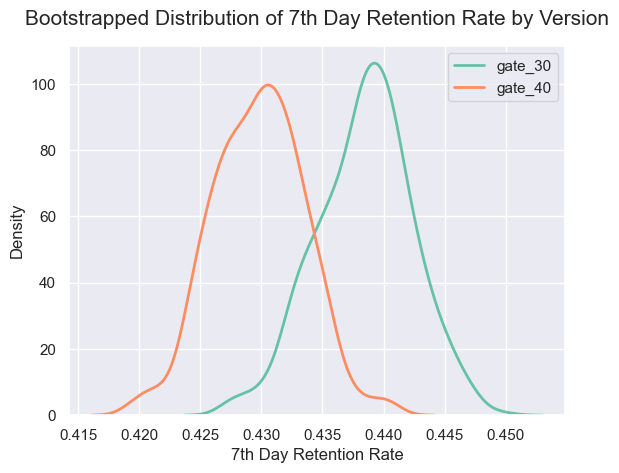

In [33]:
sns.kdeplot(boot7_df["gate_30"], linewidth=2, c=colors[0], label="gate_30")
sns.kdeplot(boot7_df["gate_40"], linewidth=2, c=colors[1], label="gate_40")
plt.title("Bootstrapped Distribution of 7th Day Retention Rate by Version", size=15, pad=15)
plt.xlabel("7th Day Retention Rate")
plt.legend()
plt.savefig("./Result/boot_version_retention_7.png", bbox_inches="tight")

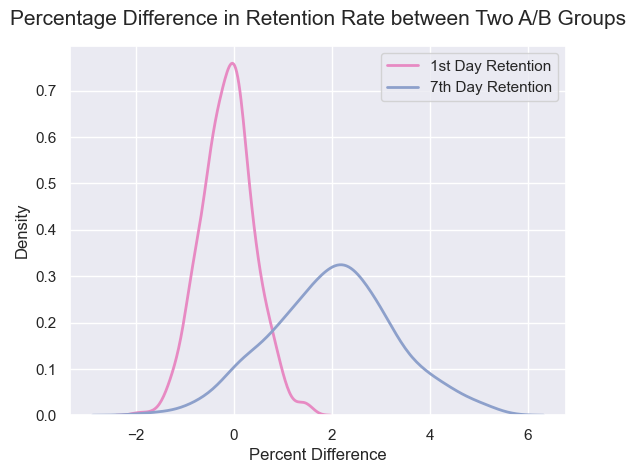

In [34]:
boot1_df["diff"] = (boot1_df.gate_30 - boot1_df.gate_40) / boot1_df.gate_40 * 100
boot7_df["diff"] = (boot7_df.gate_30 - boot7_df.gate_40) / boot7_df.gate_40 * 100


sns.kdeplot(boot1_df["diff"], linewidth=2, c=colors[3], label="1st Day Retention")
sns.kdeplot(boot7_df["diff"], linewidth=2, c=colors[2], label="7th Day Retention")
plt.xlabel("Percent Difference")
plt.title("Percentage Difference in Retention Rate between Two A/B Groups", size=15, pad=15)
plt.legend()
plt.savefig("./Result/boot_result.png", bbox_inches="tight")

In [35]:
prob_1 = (boot1_df["diff"] > 0).sum() / len(boot1_df["diff"])
prob_7 = (boot7_df["diff"] > 0).sum() / len(boot7_df["diff"])

print(f"Probability that gate_30 has a higher connection rate on the first day than gate_40 : {round(prob_1, 2) * 100}% \
      \nProbability that gate_30 has a higher connection rate on the 7th day than gate_40 : {round(prob_7, 2) * 100}% ")

Probability that gate_30 has a higher connection rate on the first day than gate_40 : 41.0%       
Probability that gate_30 has a higher connection rate on the 7th day than gate_40 : 94.0% 
